### This script is for seeing Non Maximum Suppression (NMS) for submitted answers for location identification tasks.
### There are 3 Non Maximum suppression algorithms: Slow NMS (Felzenszwalb et al.), Fast NMS, Soft-NMS with scores using Tensorflow (Greedy approach) : Scores = (1-np.exp(-1*d**2)) **
### In this script, Fast NMS and Soft NMS with Greedy approach are implemented.
### Note that Ground truth answers format is in csv file format . 

In [1]:
from PIL import Image,ImageDraw
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from math import floor

from urllib.parse import urlparse
import urllib.request, json
import requests
from io import BytesIO
import os
Image.MAX_IMAGE_PIXELS = None

import boto3
import datetime
import json
import pandas as pd
import os
from pathlib import Path
import glob
import pandas as pd
import ast

import matplotlib.pyplot as plt
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,Rectangle
from copy import copy

import matplotlib.colors
import requests
from io import BytesIO
import itertools
# Color for False and True
#cmap = matplotlib.colors.ListedColormap(['black'])

In [3]:
import import_ipynb
import helper
from helper import stringToList,stringlistToList

importing Jupyter notebook from helper.ipynb


### load the batch results for location identification task.

In [4]:
rootpath = os.path.join(os.getcwd())
output_path = os.path.join(rootpath,"batch100_HITs","results")
images_path = os.path.join(output_path,"nms")
results_path = os.path.join(rootpath,"batch100_HITs","batch_results")

### Load results from MTurk website.

In [5]:
files = os.listdir(results_path)
df = pd.read_csv(os.path.join(results_path,files[0]))
submitted_answers = df[['HITId','Answer.taskAnswers', 'WorkerId', 'WorkTimeInSeconds', 'LifetimeApprovalRate','Approve', 'Reject']]
trueids = list(submitted_answers.groupby(['WorkerId']).groups.keys())
workers_map = {'worker'+str(id):trueid for id,trueid in zip(range( len(trueids)), trueids)}
hitids = list(submitted_answers.groupby(['HITId']).groups.keys())

### Set decision boundaries to calculate the true decision boundaries for the scoring the task.

In [6]:
gsd = 0.125
image_sizes = {"0001_0001":(24174,11141),"0001_0002":(23314,13134)}
decision_boundaries = {"bus": 1.5, "small":0.9, "specialized":1.7,"truck":1.4,"trailer_large":1.5,"trailer_small":1.1, "van_rv":1.3}
boundaries = np.array(list(decision_boundaries.values()))
values = np.divide(boundaries,gsd)
radii = {}
for k,v in zip(list(decision_boundaries.keys()),values):
    radii[k] = v
class_sizes = {'bus':171, 'van_rv':127, 'small':101, 'specialized':111, 'truck':223, 'trailer_large':219, 'trailer_small':101, 'unknown':127}
values, radii, class_sizes,

(array([12. ,  7.2, 13.6, 11.2, 12. ,  8.8, 10.4]),
 {'bus': 12.0,
  'small': 7.2,
  'specialized': 13.6,
  'truck': 11.2,
  'trailer_large': 12.0,
  'trailer_small': 8.8,
  'van_rv': 10.4},
 {'bus': 171,
  'van_rv': 127,
  'small': 101,
  'specialized': 111,
  'truck': 223,
  'trailer_large': 219,
  'trailer_small': 101,
  'unknown': 127})

### Load Ground truth which are answers used for scoring.

In [7]:
file = os.path.join(output_path,"answers","answers.csv")
conv = {'# of vehicles':int,'truck':stringToList,'small':stringToList,'specialized':stringToList,'trailer_small':stringToList,'vehicle_types':stringlistToList}
answers = pd.read_csv(file, converters =conv)#,quotechar="'",sep=',') #dtype={'# of vehicles': int, 'truck':list}) #quotechar=''', sep=',',  converters={1:ast.literal_eval})
print(answers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_url      20 non-null     object
 1   url            20 non-null     object
 2   vehicle_types  20 non-null     object
 3   # of vehicles  20 non-null     int64 
 4   truck          20 non-null     object
 5   small          20 non-null     object
 6   specialized    20 non-null     object
 7   trailer_small  20 non-null     object
dtypes: int64(1), object(7)
memory usage: 1.4+ KB
None


In [8]:
workerwise_annotations = {}
imagewise_annotations = {}
urls = set()
all_dict = []
all_coordinates= []
duplicates = []
index = submitted_answers.loc[submitted_answers['WorkerId'] == trueids[0]].index[0]
ans = submitted_answers.loc[submitted_answers['WorkerId'] == trueids[0]]['Answer.taskAnswers'][index]
ans = json.loads(ans)
urls = set(ans[0].keys())
urls.remove('feedback')
for k in urls:
    workerwise_annotations[k] = {}
    imagewise_annotations[k] = {}
    for worker in trueids:
        workerwise_annotations[k][worker] = []

In [9]:
for worker in trueids:
    feedback = ""
    worker_total_scores = 0
    total_worker_time = 0
    scores = 0
    
    #get worker answers
    worker_answers = submitted_answers.loc[submitted_answers['WorkerId'] == worker]
    
    tot_vehicles = 0
    index = worker_answers.index[0]
    #get this worker answer json
    ans = worker_answers['Answer.taskAnswers'][index]

    ans = json.loads(ans)#.replace("[","").replace("]",""))
    
    for k,v in ans[0].items():
        if k != "feedback" :
            if len(urls) <=20:
                urls.add(k)
            foldername, filename = k.split("/")[6:]
            x,y = filename.split(".")[0].split("-")[2:]
            x,y = int(x),int(y)
            xy_coords = [[int(pt['x']),int(pt['y'])] for pt in v["keypoints"]]
            workerwise_annotations[k][worker]=xy_coords
            for pt in xy_coords:
                if pt in all_coordinates:
                    duplicates.append(pt)
                    #print(k, worker, pt)
            all_coordinates.extend(xy_coords)
            
print(len(urls),len(workerwise_annotations),len(all_coordinates), len(duplicates) )

20 20 61 6


In [10]:
#pd.set_option('display.max_colwidth', None)
#submitted_answers[['Answer.taskAnswers']]

In [11]:
for worker in trueids:
    feedback = ""
    worker_total_scores = 0
    total_worker_time = 0
    scores = 0
    
    #get worker answers
    worker_answers = submitted_answers.loc[submitted_answers['WorkerId'] == worker]
    
    tot_vehicles = 0
    index = worker_answers.index[0]
    #get this worker answer json
    ans = worker_answers['Answer.taskAnswers'][index]
    #print(worker,ans)

In [12]:
duplicates

[[251, 129], [122, 220], [252, 32], [177, 279], [273, 272], [147, 58]]

### Generate a dataframe by merging ground truth with that of worker's answers for each class

In [13]:
ground_truth = {}
for k in urls:
    rows = answers.loc[answers['url'] == k].fillna('')
    #if k == "https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-1920-5760.png":
        #print("rows",rows['small'].values.tolist()[0],v)
    numvehicles, trucks, small, specialized,trailersmall = rows[['# of vehicles','truck','small','specialized','trailer_small']].values.tolist()[0]
    answer_dict = {}
    this_answers = []
    foldername, filename = k.split("/")[6:]
    x,y = filename.split(".")[0].split("-")[2:]
    x,y = int(x),int(y)
    #print("x,y", x,y)
    for locations,class_name in zip([trucks, small, specialized,trailersmall],['truck','small','specialized','trailer_small']):
        if len(locations) > 0:
            locs = []
            if len(locations[0]) > 2:
                locs = [locations[0][i:i+2][::-1] for i in range(0,len(locations[0]),2)]
                for i,loc  in enumerate(locs):
                    locs[i][0] = locs[i][0] -x
                    locs[i][1] = locs[i][1]-y
                #print("locs",locs, locations)
            else:
                x1,y1 = locations[0][::-1]
                locs= [x1-x, y1-y]
            answer_dict[class_name]= locs
            this_answers.extend(locs)
            #print("xy",locs)
        else:
            answer_dict[class_name] = []
    ground_truth[k] = this_answers
    
    #'slice_loc':[x,y]
    all_dict.append({'image_url':k, trueids[0]:workerwise_annotations[k][trueids[0]], trueids[1]:workerwise_annotations[k][trueids[1]], trueids[2]:workerwise_annotations[k][trueids[2]], \
                    trueids[3]:workerwise_annotations[k][trueids[3]], trueids[4]:workerwise_annotations[k][trueids[4]], 'truck':answer_dict['truck'],'small':answer_dict['small'], 
                            'specialized':answer_dict['specialized'],'trailer_small':answer_dict['trailer_small'],'num_vehicles':numvehicles})

In [14]:
all_urls = urls.copy()

### You can remove [:2] to see all the columns. Columns are hidden for privacy of worker ids. These should remain hidden.

In [15]:
list(all_dict[0].keys())[6:]

['truck', 'small', 'specialized', 'trailer_small', 'num_vehicles']

In [16]:
df = pd.DataFrame(all_dict, index = range(1,len(all_dict)+1), columns = list(all_dict[0].keys()))

In [17]:
df[['image_url', 'truck', 'small', 'specialized', 'trailer_small', 'num_vehicles']]

image_url       truck  \
1   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
2   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
3   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   [66, 199]   
4   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
5   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  [114, 215]   
6   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
7   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
8   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
9   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
10  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
11  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
12  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
13  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
14  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
15  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
16  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
17  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
18  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
19  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   
20  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...          []   

                     small specialized trailer_small  num_vehicles  
1                       []  [152, 195]            []             1  
2                       []          []            []             0  
3                       []          []            []             1  
4                       []          []            []             0  
5                       []          []            []             1  
6                       []          []            []             0  
7                       []          []            []             0  
8               [172, 278]          []     [61, 213]             2  
9                       []          []    [287, 147]             1  
10                      []          []            []             0  
11                      []          []            []             0  
12              [274, 275]          []            []             1  
13                      []          []            []             0  
14                      []          []            []             0  
15                      []          []            []             0  
16                      []          []            []             0  
17                      []          []            []             0  
18                      []          []            []             0  
19  [[146, 60], [79, 171]]          []            []             2  
20                      []          []      [66, 63]             1

In [18]:
len(ground_truth)

20

### All image urls for this task.

In [19]:
len(urls)

20

In [20]:
df[df['image_url'] == list(urls)[19]][['image_url', 'truck', 'small', 'specialized', 'trailer_small', 'num_vehicles']] #just hiding worker Ids for privacy.

image_url truck small specialized  \
20  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...    []    []          []   

   trailer_small  num_vehicles  
20      [66, 63]             1

In [21]:
df.loc[df['image_url'] == list(urls)[19]][['image_url', 'num_vehicles']+trueids].values

array([['https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10320-5520.png',
        1, list([[150, 10]]), list([]), list([]), list([]), list([])]],
      dtype=object)

### Example of search by url

In [22]:
image_url,worker1,worker2,worker3,worker4,worker5,truck,small,specialized,trailer_small,num_vehicles = df.loc[df['image_url'] == list(urls)[19]].values.tolist()[0]
image_url,worker1,worker2,worker3,worker4,worker5,truck,small,specialized,trailer_small,num_vehicles

('https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10320-5520.png',
 [[150, 10]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [66, 63],
 1)

### This may help if you like to revert the coordinates locations from smaller images back to original main image. So the following two cells provide how to translate to original locations.

In [23]:
for url in urls:
    image_url,worker1,worker2,worker3,worker4,worker5,truck,small,specialized,trailer_small,num_vehicles = df.loc[df['image_url'] == url].values.tolist()[0]
    workers_ann = list(worker1+worker2+worker3+worker4+worker5)
    imagewise_annotations[url]=[]
    imagewise_annotations[url] = workers_ann

In [24]:
len(imagewise_annotations), len(urls)

(20, 20)

### Visualize decision boundaries to location markings from annotations

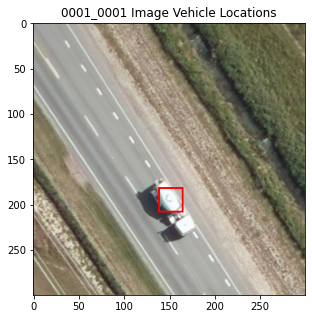

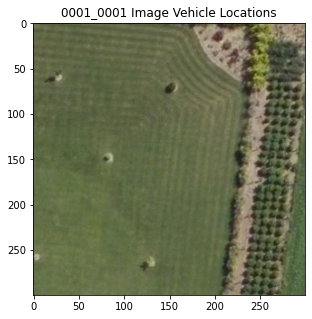

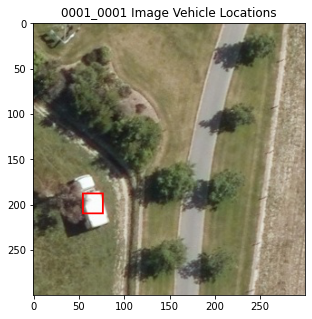

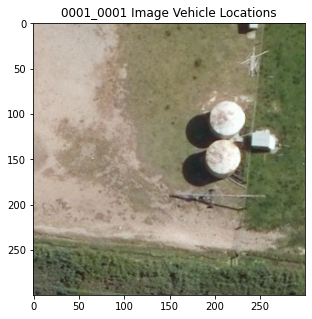

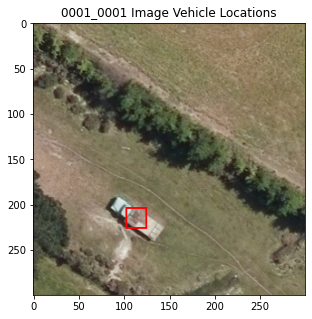

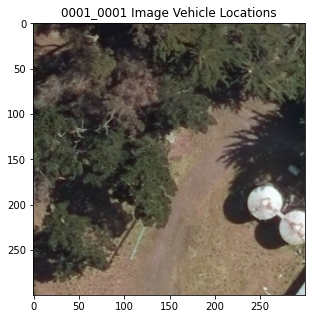

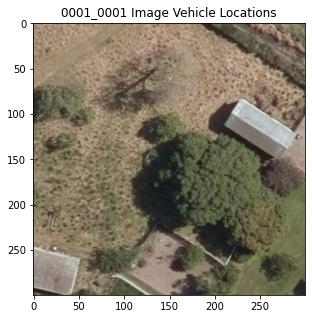

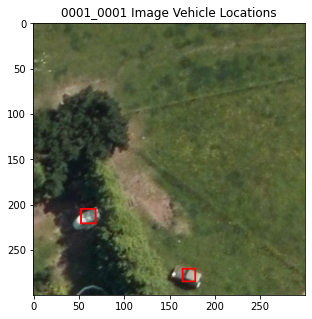

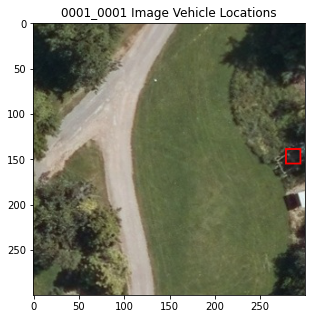

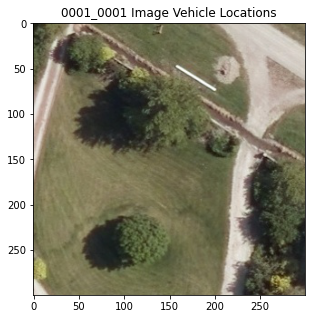

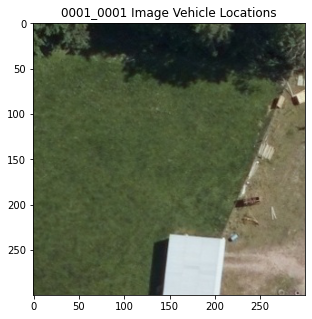

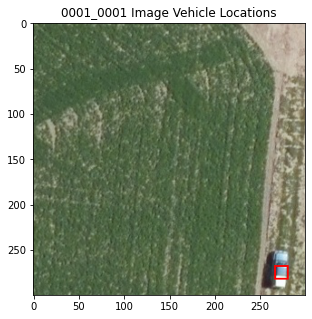

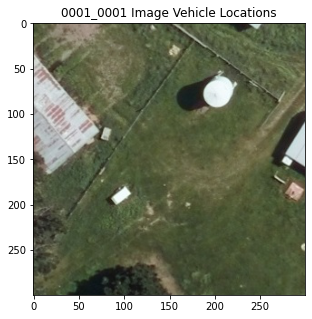

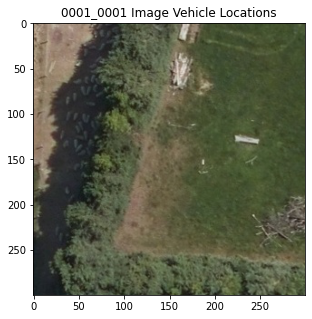

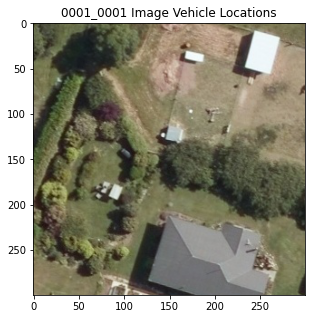

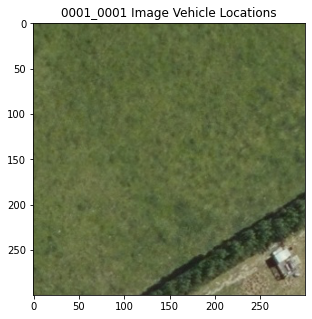

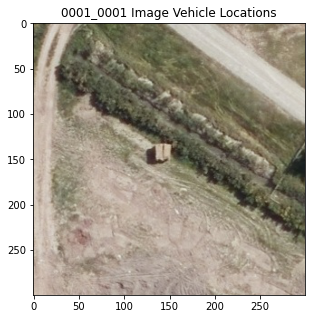

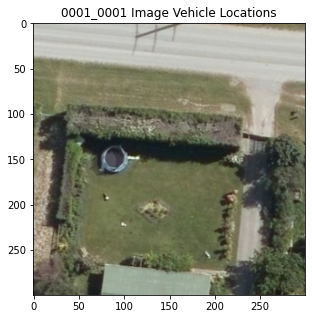

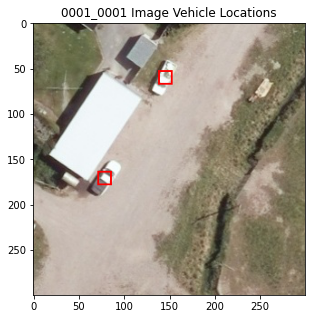

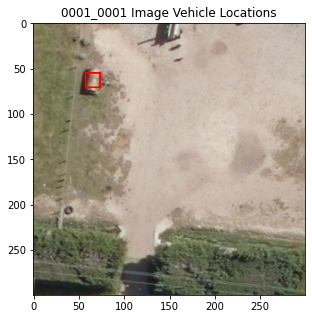

In [25]:
classwise_gt = {'truck':[], 'small':[], 'specialized':[], 'trailer_small':[]}
url_class_gt = {'truck':{}, 'small':{}, 'specialized':{}, 'trailer_small':{}}
w,h = 300,300 #inputImageProperties
for url in urls:
    
    image_url,truck,small,specialized,trailer_small,num_vehicles = df.loc[df['image_url'] == url][['image_url', 'truck', 'small', 'specialized', 'trailer_small', 'num_vehicles']].values.tolist()[0]
    imname = os.path.basename(image_url)
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    
    draw = ImageDraw.Draw(img)
    cols = itertools.cycle([(255,0,0,0),(255,255,0,0),(202, 44, 146,0)])
    l = [truck,small,specialized,trailer_small]
    
    #slice locations from main image, in case to load main image crop from original
    
    for locations,class_name in zip(l,['truck','small','specialized','trailer_small']): #,'trailer_small']):
        locs = []
        #print(locations, len(locations))
        if len(locations) > 1:
            
            #for x1,y1 in zip(locations[0], locations[1]):
            if type(locations[0]) == list:
                for loc in locations:
                    locs.append(loc)
                    #print(loc)
            else: 
                locs.append([locations[0],locations[1]])
                #print("int",[locations[0],locations[1]])
            url_class_gt[class_name][url] = locations
            classwise_gt[class_name].append(locations)
            #print(classwise_gt)
        elif len(locations) == 1:
            
            x2,y2 = locations[0]
            locs.append( [x2,y2])
            classwise_gt[class_name].append(locations)
            url_class_gt[class_name][url] = locations
            #print(classwise_gt)
        else:
            locs = []
        
        radius = radii[class_name]
        
        #classwise_gt[class_name] = locations
        for row, col in locs:
            #mask = np.sqrt((rows - row)**2 + (cols - col)**2) <= radius
            #local_sum.append(np.sum(mask*img))
            #print((row-radius, col-radius, row+radius, col+radius),img.size,radius)
            size = radii[class_name]
            #print(( row-size,col-size,  row+size,col+size,))
            draw.rectangle(( row-size,col-size,  row+size,col+size,),outline=(255,0,0,0), width=2)

        #ax.imshow(img,cmap=cmap)
        #for i, [row, col] in enumerate(xy):
            #ax.add_patch(Circle((col, row), radius=75, color='red'))
            #ax.add_patch(Rectangle((col+size, row+size),class_sizes[class_name],class_sizes[class_name], color='red',fill=None))
            #plt.text(col, row, '{:.2f}'.format(local_sum[i]), ha='center', va='center')
        
    img.convert('RGB') .save(os.path.join(images_path,"test",imname))
    w,h = img.size
    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(img))
    plt.title("0001_0001 Image Vehicle Locations")

In [26]:
classwise_gt,url_class_gt

({'truck': [[66, 199], [114, 215]],
  'small': [[172, 278], [274, 275], [[146, 60], [79, 171]]],
  'specialized': [[152, 195]],
  'trailer_small': [[61, 213], [287, 147], [66, 63]]},
 {'truck': {'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-12960-4800.png': [66,
    199],
   'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10560-9840.png': [114,
    215]},
  'small': {'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-5040-3600.png': [172,
    278],
   'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-22320-3840.png': [274,
    275],
   'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-9120-9600.png': [[146,
     60],
    [79, 171]]},
  'specialized': {'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-7440-3600.png': [152,
    195]},
  'trailer_small': {'https://mturk-s3-cg.s3.amazonaws.com/ta

In [27]:
def url_to_pilimage(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # return the image
    return img

### The following NMS method is Soft NMS with Greedy approach using Tensorflow library.
### The function expects image url with multiple bounding boxes submitted by workers, ground truth, center locations, selected ids based on scores from exponential L2 Norm.

In [28]:
def soft_nms(img_url, bboxes, scores,numvehicles, groundtruth, centers, ids):

    imname = os.path.basename(img_url)
    
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(
        bboxes, scores, numvehicles, iou_threshold=0.5,
        score_threshold=float('-inf'), soft_nms_sigma=0.5)
    
    image = url_to_pilimage(img_url)
    orig = image.copy()
    
    draw = ImageDraw.Draw(orig)
    # loop over the bounding boxes for each image and draw them
    for (startX, startY, endX, endY) in bboxes:
        draw.rectangle((startX, startY, endX, endY),outline=(255,0,0,0), width=2)
    for (cx,cy) in groundtruth:
        draw.point((cy+1, cx-1, cy+1, cx+1),fill=(0,0,255,0))
    for (cx,cy) in centers:
        draw.point((cy-1, cx-1, cy+1, cx+1),fill=(0,0,255,0))
    orig.convert('RGB').save(os.path.join(images_path,"worker_annotations",imname))
    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(orig))
    plt.title("Orig")
    
    draw = ImageDraw.Draw(image)

    # perform non-maximum suppression on the bounding boxes
    pick = bboxes[selected_indices.numpy()]
    #print("selected",pick,selected_indices.numpy())
    print("[x] after applying non-maximum suppression, %d bounding boxes" % (len(pick)))
    # loop over the picked bounding boxes and draw them
    for (startX, startY, endX, endY) in pick:
        draw.rectangle((startX, startY, endX, endY),outline=(0,255,0,0), width=2)
    # display the images
    
    image.convert('RGB').save(os.path.join(images_path,"bb_nms_annotations","new1",imname))
    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(image))
    plt.title("After soft NMS")

### Plot the annotations for all bounding boxes received

In [29]:
def plot_this_annotations(img_url, bboxes,numvehicles, groundtruth, centers, worker):
    
    imname = os.path.basename(img_url)
    
    image = url_to_pilimage(img_url)
    orig = image.copy()
    
    draw = ImageDraw.Draw(orig)
    # loop over the bounding boxes for each image and draw them
    for (startX, startY, endX, endY) in bboxes:
        draw.rectangle((startX, startY, endX, endY),outline=(255,0,0,0), width=2)
    for (cx,cy) in groundtruth:
        draw.ellipse((cy-1, cx-1, cy+1, cx+1),fill=(0,0,255,0))
    for (cx,cy) in centers:
        draw.ellipse((cy-1, cx-1, cy+1, cx+1),fill=(255,0,0,0))
    orig.convert('RGB').save(os.path.join(images_path,"worker_annotations","invalid",worker+"_"+imname))
    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(orig))
    plt.title("Worker "+ worker + " Annotations")

### The following scoring method takes L2 norm between received bounding boxes and ground truth and based on nearest distacnes that match the tolerance radii,
### generates L2 Norm (Euclidean distances) to Gaussian kernel which serves as similarity score. (Suggested by Stan)

In [30]:
def get_scores(centers,groundtruth, class_name, numvehicles, radius):
    # if there are no boxes, return an empty list
    if len(centers) == 0:
        return []
    #initialize distances, ids
    distances = [None]*len(centers)
    ids = []
    scores= []
    #get L2 norm
    for i,center in enumerate(centers):
        dist = np.linalg.norm( groundtruth-center, axis=1)
        ind = np.where(dist <= radius)
        
        if not np.size(ind):
            distances[i] = -1
            #scores.append(0)
        elif len(ind[0]) > 1:
            ids.append(i)
            distances[i] = dist[j][0]
        else:
            ids.append(i)
            distances[i] = dist[ind][0]
            scores.append(1)
    scores = []
    for i,d in enumerate(distances):
        scores.append(1-np.exp(-1*d**2)) #s = 1 constant, s^2 = 1 -> denominator to kernel function
    for id in ids:
        if distances[id] == -1:
            scores[id] = 0
    #print("scores", scores, distances)
    return [scores, distances, ids]

[x] after applying non-maximum suppression, 1 bounding boxes
[x] after applying non-maximum suppression, 1 bounding boxes
[x] after applying non-maximum suppression, 1 bounding boxes
[x] after applying non-maximum suppression, 2 bounding boxes
[x] after applying non-maximum suppression, 2 bounding boxes
[x] after applying non-maximum suppression, 1 bounding boxes
[x] after applying non-maximum suppression, 2 bounding boxes
[x] after applying non-maximum suppression, 1 bounding boxes


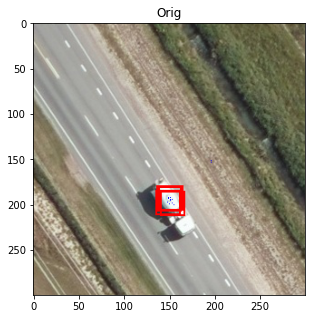

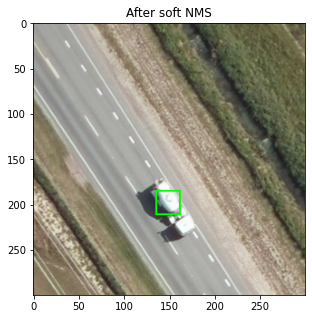

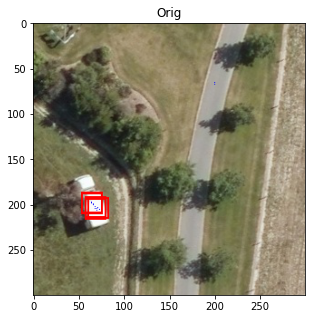

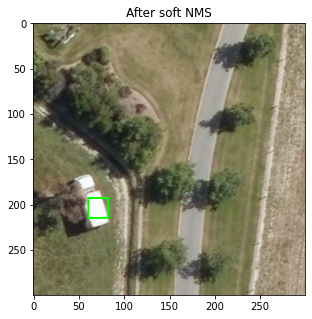

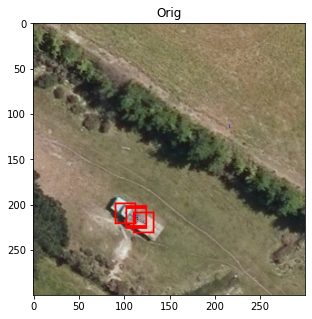

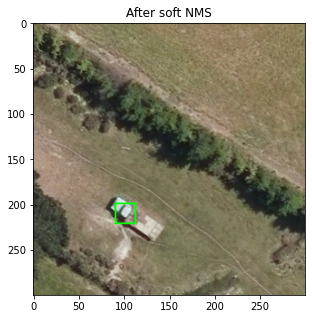

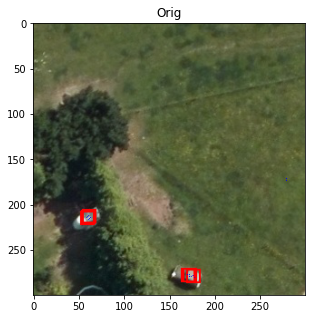

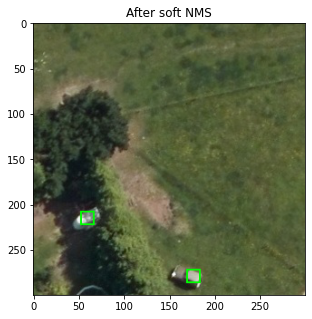

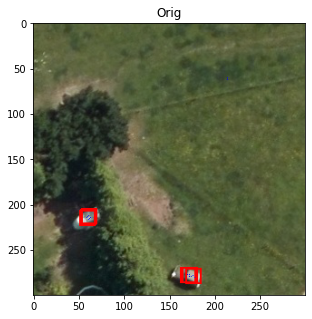

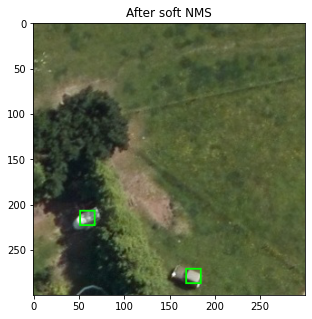

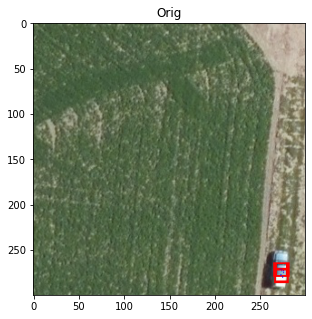

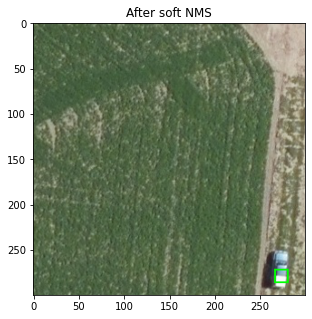

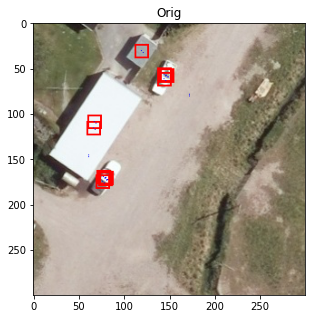

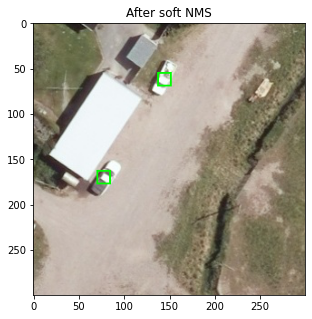

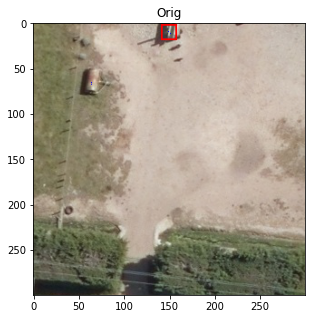

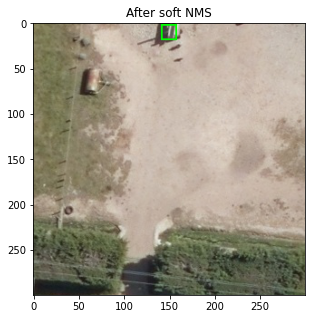

In [31]:
w,h = 300,300 #inputImageProperties

# fotr each image url
for url in urls:
    
    # get all entries for this row from dataframe
    image_url,worker1,worker2,worker3,worker4,worker5,truck,small,specialized,trailer_small,num_vehicles = df.loc[df['image_url'] == url].values.tolist()[0]
    imname = os.path.basename(image_url)

    #cols = itertools.cycle([(255,0,0,0),(255,255,0,0),(202, 44, 146,0)])
    l = [truck,small,specialized,trailer_small]
    
    # for each class specific location
    # we need the class label to get the specific tolerance level for a marked location submitted by worker
    for locations,class_name in zip( l,['truck','small','specialized','trailer_small']): #,'trailer_small']):
        locs = []
        if len(locations) > 1:
            
            #for x1,y1 in zip(locations[0], locations[1]):
            if type(locations[0]) == list:
                for loc in locations:
                    locs.append(loc)
            else: 
                locs.append([locations[0],locations[1]])
        elif len(locations) == 1:
            
            x2,y2 = locations[0]
            locs.append( [x2,y2])
        else:
            locs = []
        xy = np.array(locs, dtype='int')
        radius = radii[class_name]
        gt = []
        c = []
        bb = []
        for row, col in locs:
            size = radii[class_name]
            #print("locs",row, col)
            gt.append([row, col])

        for worker in [worker1,worker2,worker3,worker4,worker5]:
            if len(worker) > 0:
                for loc in worker:
                    row,col = loc
                    #print("loc, row, col",loc[::-1], col, row)
                    c.append(loc[::-1])
                    bb.append([ row-size, col-size, row+size,col+size])
            
        if len(bb) > 0 and len(gt) > 0:
            centers = np.array(c)
            groundtruth = np.array(gt)
            bboxes = np.array(bb)
        
            scores, distances, ids = get_scores(centers,groundtruth, class_name, numvehicles, radii[class_name])
            #print(url,scores, distances)
            soft_nms(url,bboxes, scores,num_vehicles, groundtruth, centers, ids)    


In [32]:
def get_scores_distances(centers,groundtruth, class_name, numvehicles, radius):
    
    """This method calcualates Euclidean distances between annotation coordinates and ground truth, 
        filters distances that satisfy tolerance radii of given annotation (calculated based on Ground sampling distance)
        Then find Similarity scores for Squared Euclidean distances to calculate True positives and False Positives
    """
    
    #print(centers,groundtruth, class_name, numvehicles, radius)
    distances = [-1]*len(centers)
    ids = []
    fp_locs = []
    tp_locs = []
    invalid = []
    fp = 0
    tp = 0
    
    sigma = 2 * radius/3
    beta = 1/(2*sigma*sigma)
    sigmasqrtpi = 1/(np.sqrt(2*np.pi)*sigma)
    rows1, rows2 = centers.shape[0], groundtruth.shape[0]
    ind = None
    #distances = np.linalg.norm( groundtruth-centers[:,None], axis=1)
    #ind = np.where(distances <= radius)
    for i,center in enumerate(centers):
        dist = np.linalg.norm( groundtruth-center, axis=0)
    #print(i,center,groundtruth, dist, radius)
        ind = np.where(dist <= radius)
        if not np.size(ind):
            invalid.append(center.tolist())
            distances[i] = -1
        elif len(ind[0]) > 1:
            ids.append(i)
            #print(dist, dist[ind])
            distances[i] = dist[ind][0]
        else:
            ids.append(i)
            #print(type(dist))
            if type(dist) == np.float64:
                distances[i] = dist
            else:
                distances[i] = dist[ind][0]
  
    #print("all",distances, ids)

    scores=  [-1]*len(centers)
    if len(ids) > 0:
        for i,d in enumerate(distances):
            if i in ids:
                #print(i, len(scores), scores)
                scores[i] = sigmasqrtpi * np.exp(-1*d*d*beta ) # Gaussian kernel for similarity scores
    if len(scores) == 0:
        fp += len(distances)
        fp_locs.append(centers[ids].tolist())
    else:
        #The following condition only identified True positives and False positives.
        for centerloc, score, distance in zip(centers, scores, distances):
            #print(centerloc, score, distance, type(distance), type(score), type(centerloc))
             #if scores and distances are positive meaning "this" annotations are true positive
            if np.all((score > 0)) and np.all((distance >= 0.)) and len(centerloc) > 0 :
                tp += 1
                tp_locs.append(centerloc.tolist())
            elif np.all((score < 0)) and np.all((distance < 0.)) and len(centerloc) > 0:
                fp += 1
                fp_locs.append(centerloc.tolist())
            else:
                fp += 1
                fp_locs.append(centerloc.tolist())
    #print("scores",scores, distances)
    return [scores, distances ,fp_locs,tp_locs,invalid,tp,fp, ids]

In [33]:
def get_scores(worker_annotations, gt:list,numvehicles:int, url:str, workerid:int, class_name:str, radii:float):
    """
    This method calculates True positives, False positives, True negatives and False negatives for given set of worker annotations
    and the ground truth corodinate pairs for each worker.
    """
    c = []
    bb = []
    fp,fn,tp,tn =[0,0,0,0]
    fp_locs,fn_locs,tp_locs,tn_locs =[[],[],[],[]]
    for loc in worker_annotations:
        row,col = loc
        c.append(loc)
        bb.append([ row-size, col-size, row+size,col+size])
    
    #print(len(bb),bb, gt, c)
    ## Case 1 : expected number of vehicles and annotations are non-empty
    if len(bb) > 0 and numvehicles > 0:
        centers = np.array(c)
        groundtruth = np.array(gt)
        bboxes = np.array(bb)
        ## condition 1 : Ground truth and worker annotations are non-empty, so calculate scores n distances method calculate similarity scores for TP and FP
    scores, distances ,fp_locs,tp_locs,invalid,tp,fp, ids = get_scores_distances(centers,groundtruth, class_name, numvehicles, radii)

    #validate fp+fn+tp+tn == len(distances) : distances can contain 0.0 or positive values or negative values for annotations over the tolerance radii.
    assert fp+fn+tp+tn == len(distances)," len(gt) > 0Mismatch in counts. %d,%d"%(fp+fn+tp+tn, len(c))
    return {"worker":str(workerid), "url":url, "vehicle_class":class_name,"num_vehicles":numvehicles, "groundtruth":gt, "annotations":c,
                          "num_annotations":len(c),"fp_locs":fp_locs,"tp_locs":tp_locs,"fn_locs":[],"tn_locs":[],"invalid":[], 
                        "tp":tp,"fp":fp,"tn":tn,"fn":fn, "scores":scores,"distances":distances}

In [34]:
len(all_urls), len(set(all_urls))

(20, 20)

In [35]:
len(ground_truth),len(all_coordinates), len(imagewise_annotations), len(duplicates), len(url_class_gt)

(20, 61, 20, 6, 4)

In [36]:
visitedlist = {}
duplicatecoords = []
for coord in all_coordinates:
    print(coord)
    if tuple(coord) not in visitedlist.keys():
        visitedlist[tuple(coord)] = {0:False,1:False,2:False,3:False,4:False}
    else:
        duplicatecoords.append(tuple(coord))
len(visitedlist), len(all_coordinates), len(duplicatecoords), visitedlist[duplicatecoords[0]]

[250, 264]
[276, 265]
[72, 204]
[62, 19]
[149, 198]
[184, 275]
[150, 10]
[209, 148]
[216, 105]
[102, 210]
[273, 272]
[60, 215]
[99, 187]
[78, 170]
[145, 62]
[69, 205]
[152, 193]
[172, 295]
[251, 129]
[122, 220]
[252, 32]
[178, 37]
[274, 279]
[177, 279]
[61, 214]
[1, 267]
[68, 109]
[148, 58]
[80, 171]
[276, 256]
[69, 203]
[150, 194]
[168, 295]
[251, 129]
[122, 220]
[252, 32]
[177, 37]
[274, 278]
[177, 279]
[62, 213]
[299, 133]
[4, 269]
[81, 171]
[147, 58]
[67, 116]
[120, 31]
[65, 199]
[154, 199]
[114, 213]
[102, 144]
[273, 272]
[171, 278]
[80, 172]
[147, 58]
[65, 198]
[150, 193]
[114, 215]
[275, 272]
[173, 278]
[145, 57]
[77, 175]


(55, 61, 6, {0: False, 1: False, 2: False, 3: False, 4: False})

In [37]:
def mark_visited(curr_annotations:list, visitedlist:list, workerid:int):
        is_list_coords = all(isinstance(x, list) for x in curr_annotations)
        if is_list_coords:
            try:
                for curr_annotation in curr_annotations:
                    if tuple(curr_annotation) in visitedlist.keys():
                        if not visitedlist[tuple(curr_annotation)][workerid]:
                            visitedlist[tuple(curr_annotation)][workerid] = True
                        return visitedlist
                    print("Unexpected error: This coordinates not in visitedlist",curr_annotation )
                    return visitedlist
            except:
                print("Unexpected error: This coordinates not in visitedlist",curr_annotation )
                return visitedlist
        else:
            if tuple(curr_annotations) in visitedlist.keys():
                if not visitedlist[tuple(curr_annotations)][workerid]:
                    visitedlist[tuple(curr_annotations)][workerid] = True
                    return visitedlist
                print("Unexpected error: This coordinates not in visitedlist",curr_annotation[0] )
                return visitedlist
        
def is_visited(curr_annotations:list, visitedlist:list, workerid:int):
    is_list_coords = all(isinstance(x, list) for x in curr_annotations)
    if is_list_coords:
        for curr_annotation in curr_annotations:
            print(curr_annotation)
            if tuple(curr_annotation) in visitedlist.keys():
                return visitedlist[tuple(curr_annotation)][workerid]
            else:
                if tuple(curr_annotation) in duplicatecoords:
                    return visitedlist[tuple(curr_annotation)][workerid]
                print("Unexpected error: This coordinates not in visitedlist",curr_annotation )
                return visitedlist
    else:
        return visitedlist[tuple(curr_annotations)][workerid]

In [38]:
workerwise_scores = []

In [39]:
for classname,values in url_class_gt.items():
    for url,this_gt in values.items():
        num_vehicles,worker1_ann,worker2_ann,worker3_ann,worker4_ann,worker5_ann = df.loc[df['image_url'] == url][['num_vehicles']+trueids].values.tolist()[0]
        #print(url, classname, this_gt,num_vehicles,worker1_ann,worker2_ann,worker3_ann,worker4_ann,worker5_ann)
        is_list_coords = all(isinstance(x, list) for x in this_gt)
        #print(is_list_coords)
        for i,this_worker_annotation in {0:worker1_ann, 1:worker2_ann, 2:worker3_ann, 3:worker4_ann, 4:worker5_ann}.items():
            fp, tp, fn, tn = [0,0,0,0]
            #print("this_worker_annotation", this_worker_annotation, len(this_worker_annotation))
            if len(this_worker_annotation) == 0 and is_list_coords:
                fn = len(this_gt)
                workerwise_scores.append({"worker":str(i), "url":url, "vehicle_class":class_name,"num_vehicles":len(this_gt), "groundtruth":[], "annotations":[],
                                            "num_annotations":0,"fp_locs":[],"tp_locs":[],"fn_locs":[],
                              "tn_locs":[], "invalid":[],"tp":0,"fp":0,"tn":0,"fn":fn,"scores":[],"distances":[]})
                
            elif len(this_worker_annotation) == 0 and not is_list_coords:
                fn = 1
                workerwise_scores.append({"worker":str(i), "url":url, "vehicle_class":class_name,"num_vehicles":0, "groundtruth":[], "annotations":[],
                                            "num_annotations":0,"fp_locs":[],"tp_locs":[],"fn_locs":[],
                              "tn_locs":[], "invalid":[],"tp":0,"fp":0,"tn":0,"fn":fn,"scores":[],"distances":[]})
                
            elif len(this_worker_annotation) > 0:
                is_list_ann_coords = all(isinstance(x, list) for x in this_worker_annotation)
                print(is_list_ann_coords)
                if is_list_ann_coords:
                    for curr_annotation in this_worker_annotation:
                        print(curr_annotation,is_visited(curr_annotation, visitedlist, i))
                        if not is_visited(curr_annotation, visitedlist, i):

                            this_worker_score = get_scores([curr_annotation], this_gt, num_vehicles, url, i, classname,radii[classname] )
                            visitedlist = mark_visited(curr_annotation, visitedlist, i)
                            #print(this_worker_score)
                            workerwise_scores.append(this_worker_score)
                else:
                    if not is_visited(this_worker_annotation, visitedlist, i):
                        visitedlist = mark_visited(this_worker_annotation, visitedlist, i)
                        this_worker_score = get_scores(this_worker_annotation, this_gt, num_vehicles, url, i, classname,radii[classname] )
                        workerwise_scores.append(this_worker_score)

True
[72, 204] False
True
[69, 205] False
True
[69, 203] False
True
[65, 199] False
True
[65, 198] False
True
[102, 210] False
True
[122, 220] False
True
[122, 220] False
True
[114, 213] False
True
[114, 215] False
True
[60, 215] False
True
[177, 279] False
[61, 214] False
True
[177, 279] False
[62, 213] False
True
[171, 278] False
True
[173, 278] False
True
[273, 272] False
True
[274, 279] False
True
[274, 278] False
True
[273, 272] False
True
[275, 272] False
True
[78, 170] False
[145, 62] False
True
[68, 109] False
[148, 58] False
[80, 171] False
True
[81, 171] False
[147, 58] False
[67, 116] False
[120, 31] False
True
[80, 172] False
[147, 58] False
True
[145, 57] False
[77, 175] False
True
[149, 198] False
True
[152, 193] False
True
[150, 194] False
True
[154, 199] False
True
[150, 193] False
True
[60, 215] True
True
[177, 279] True
[61, 214] True
True
[177, 279] True
[62, 213] True
True
[171, 278] True
True
[173, 278] True
True
[150, 10] False


In [40]:
len(visitedlist),visitedlist[duplicatecoords[0]],duplicatecoords[0]

(55, {0: False, 1: False, 2: False, 3: False, 4: False}, (251, 129))

In [41]:
for url in urls:
    if url not in url_class_gt.keys():
        #print(url)
        num_vehicles,worker1_ann,worker2_ann,worker3_ann,worker4_ann,worker5_ann = df.loc[df['image_url'] == url][['num_vehicles']+trueids].values.tolist()[0]
        for i,this_worker_annotation in {0:worker1_ann, 1:worker2_ann, 2:worker3_ann, 3:worker4_ann, 4:worker5_ann}.items():
            #print(i,len(this_worker_annotation ))
            is_list_coords = all(isinstance(x, list) for x in this_worker_annotation)
            if is_list_coords:
                for curr_annotation in this_worker_annotation:
                    if not is_visited(curr_annotation, visitedlist, i):
                        workerwise_scores.append({"worker":str(i), "url":url, "vehicle_class":None,"num_vehicles":0, "groundtruth":[], "annotations":curr_annotation,
                                                        "num_annotations":0,"fp_locs":[],"tp_locs":[],"fn_locs":[],
                                          "tn_locs":curr_annotation, "invalid":[],"tp":0,"fp":0,"tn":1,"fn":0,"scores":[],"distances":[]})
                        visitedlist = mark_visited(curr_annotation, visitedlist, i)
            else:
                if not is_visited(this_worker_annotation, visitedlist, i):
                    workerwise_scores.append({"worker":str(i), "url":url, "vehicle_class":None,"num_vehicles":0, "groundtruth":[], "annotations":this_worker_annotation,
                                                    "num_annotations":0,"fp_locs":[],"tp_locs":[],"fn_locs":[],
                                      "tn_locs":this_worker_annotation, "invalid":[],"tp":0,"fp":0,"tn":1,"fn":0,"scores":[],"distances":[]})
                    visitedlist = mark_visited(this_worker_annotation, visitedlist, i)

In [42]:
len(visitedlist),visitedlist[duplicatecoords[0]],duplicatecoords[0]

(55, {0: False, 1: True, 2: True, 3: False, 4: False}, (251, 129))

In [43]:
len(workerwise_scores)

70

In [44]:
len(imagewise_annotations), len(imagewise_annotations.keys())

(20, 20)

In [45]:
url_visitedlist = {}
duplicatecoords = []
for coord in all_coordinates:
    print(coord)
    if tuple(coord) not in url_visitedlist.keys():
        url_visitedlist[tuple(coord)] = {url:False for url in list(imagewise_annotations.keys())}
    else:
        duplicatecoords.append(tuple(coord))
len(url_visitedlist), len(all_coordinates), len(duplicatecoords), url_visitedlist[duplicatecoords[0]]

[250, 264]
[276, 265]
[72, 204]
[62, 19]
[149, 198]
[184, 275]
[150, 10]
[209, 148]
[216, 105]
[102, 210]
[273, 272]
[60, 215]
[99, 187]
[78, 170]
[145, 62]
[69, 205]
[152, 193]
[172, 295]
[251, 129]
[122, 220]
[252, 32]
[178, 37]
[274, 279]
[177, 279]
[61, 214]
[1, 267]
[68, 109]
[148, 58]
[80, 171]
[276, 256]
[69, 203]
[150, 194]
[168, 295]
[251, 129]
[122, 220]
[252, 32]
[177, 37]
[274, 278]
[177, 279]
[62, 213]
[299, 133]
[4, 269]
[81, 171]
[147, 58]
[67, 116]
[120, 31]
[65, 199]
[154, 199]
[114, 213]
[102, 144]
[273, 272]
[171, 278]
[80, 172]
[147, 58]
[65, 198]
[150, 193]
[114, 215]
[275, 272]
[173, 278]
[145, 57]
[77, 175]


(55,
 61,
 6,
 {'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-7440-3600.png': False,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-15600-2880.png': False,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-12960-4800.png': False,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10560-5520.png': False,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10560-9840.png': False,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-8400-9360.png': False,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-8880-9120.png': False,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-5040-3600.png': False,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-6240-6240.png': False,
  'https://mturk-s3

In [46]:
def mark_visited_coord_url(curr_annotations:list, url_visitedlist:list, url:str):
        is_list_coords = all(isinstance(x, list) for x in curr_annotations)
        if is_list_coords:
            try:
                for curr_annotation in curr_annotations:
                    if tuple(curr_annotation) in url_visitedlist.keys():
                        if not url_visitedlist[tuple(curr_annotation)][url]:
                            url_visitedlist[tuple(curr_annotation)][url] = True
                        return url_visitedlist
                    print("Unexpected error: This coordinates not in url_visitedlist",curr_annotation )
                    return url_visitedlist
            except:
                print("Unexpected error: This coordinates not in url_visitedlist",curr_annotation )
                return url_visitedlist
        else:
            if tuple(curr_annotations) in url_visitedlist.keys():
                if not url_visitedlist[tuple(curr_annotations)][url]:
                    url_visitedlist[tuple(curr_annotations)][url] = True
                    return url_visitedlist
                print("Unexpected error: This coordinates not in url_visitedlist",curr_annotation[0] )
                return url_visitedlist
        
def is_url_coord_visited(curr_annotations:list, url_visitedlist:list, url:str):
    is_list_coords = all(isinstance(x, list) for x in curr_annotations)
    if is_list_coords:
        for curr_annotation in curr_annotations:
            print(curr_annotation)
            if tuple(curr_annotation) in url_visitedlist.keys():
                return url_visitedlist[tuple(curr_annotation)][url]
            else:
                if tuple(curr_annotation) in duplicatecoords:
                    return url_visitedlist[tuple(curr_annotation)][url]
                print("Unexpected error: This coordinates not in url_visitedlist",curr_annotation )
                return url_visitedlist
    else:
        return url_visitedlist[tuple(curr_annotations)][url]

In [47]:
imagewise_scores = []

In [48]:
imagewise_annotations

{'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-7440-3600.png': [[149,
   198],
  [152, 193],
  [150, 194],
  [154, 199],
  [150, 193]],
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-15600-2880.png': [[62,
   19]],
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-12960-4800.png': [[72,
   204],
  [69, 205],
  [69, 203],
  [65, 199],
  [65, 198]],
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10560-5520.png': [[209,
   148],
  [216, 105],
  [251, 129],
  [251, 129]],
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10560-9840.png': [[102,
   210],
  [122, 220],
  [122, 220],
  [114, 213],
  [114, 215]],
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-8400-9360.png': [],
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-8880-9120.png': [[1,
   267

In [49]:
for classname,values in url_class_gt.items():
    for url,this_gt in values.items():
        imagewise_annotations
        num_vehicles = df.loc[df['image_url'] == url][['num_vehicles']].values.tolist()[0][0]
        #print(url, classname, this_gt,num_vehicles,worker1_ann,worker2_ann,worker3_ann,worker4_ann,worker5_ann)
        is_list_coords = all(isinstance(x, list) for x in this_gt)
        #print(is_list_coords)
        this_image_annotation = imagewise_annotations[url]
        fp, tp, fn, tn = [0,0,0,0]
        #print("this_image_annotation", this_image_annotation, len(this_image_annotation),num_vehicles)
        if len(this_image_annotation) == 0 and is_list_coords:
            fn = len(this_gt)
            #print(fn,this_image_annotation)
            imagewise_scores.append({ "url":url, "vehicle_class":class_name,"num_vehicles":len(this_gt), "groundtruth":[], "annotations":[],
                                        "num_annotations":0,"fp_locs":[],"tp_locs":[],"fn_locs":[],
                          "tn_locs":[], "invalid":[],"tp":0,"fp":0,"tn":0,"fn":fn,"scores":[],"distances":[]})

        elif len(this_image_annotation) == 0 and not is_list_coords:
            fn = 1
            #print(fn,this_image_annotation)
            imagewise_scores.append({"url":url, "vehicle_class":class_name,"num_vehicles":0, "groundtruth":[], "annotations":[],
                                        "num_annotations":0,"fp_locs":[],"tp_locs":[],"fn_locs":[],
                          "tn_locs":[], "invalid":[],"tp":0,"fp":0,"tn":0,"fn":fn,"scores":[],"distances":[]})

        elif len(this_image_annotation) > 0:
            is_list_coords = all(isinstance(x, list) for x in this_image_annotation)
            if is_list_coords:
                for curr_annotation in this_image_annotation:
                    if not is_url_coord_visited(curr_annotation, url_visitedlist,url):
                        this_image_score = get_scores([curr_annotation],this_gt, num_vehicles, url, i, classname,radii[classname] )
                        this_score = {"url":url, "vehicle_class":class_name,"num_vehicles":numvehicles, "groundtruth":this_image_score["groundtruth"], "annotations":this_image_score["annotations"],
                                      "num_annotations":this_image_score["num_annotations"],"fp_locs":this_image_score["fp_locs"],"tp_locs":this_image_score["tp_locs"],"fn_locs":this_image_score["fn_locs"],
                                      "tn_locs":this_image_score["tn_locs"],"invalid":this_image_score["invalid"], 
                                    "tp":this_image_score["tp"],"fp":this_image_score["fp"],"tn":this_image_score["tn"],"fn":this_image_score["fn"], 
                                      "scores":this_image_score["scores"],"distances":this_image_score["distances"]}

                        #print(this_worker_score)
                        imagewise_scores.append(this_score)
                        url_visitedlist = mark_visited_coord_url(curr_annotation, url_visitedlist, url)
            else:
                
                if not is_url_coord_visited(this_image_annotation, url_visitedlist,url):
                    this_image_score = get_scores(this_image_annotation, this_gt, num_vehicles, url, i, classname,radii[classname] )
                    
                    this_score = {"url":url, "vehicle_class":class_name,"num_vehicles":numvehicles, "groundtruth":this_image_score["groundtruth"], "annotations":this_image_score["annotations"],
                                  "num_annotations":this_image_score["num_annotations"],"fp_locs":this_image_score["fp_locs"],"tp_locs":this_image_score["tp_locs"],"fn_locs":this_image_score["fn_locs"],
                                  "tn_locs":this_image_score["tn_locs"],"invalid":this_image_score["invalid"], 
                                "tp":this_image_score["tp"],"fp":this_image_score["fp"],"tn":this_image_score["tn"],"fn":this_image_score["fn"], 
                                  "scores":this_image_score["scores"],"distances":this_image_score["distances"]}

                    #print(this_worker_score)
                    imagewise_scores.append(this_score)
                    url_visitedlist = mark_visited_coord_url(this_image_annotation, url_visitedlist, url)

In [50]:
for url in urls:
    if url not in url_class_gt.keys():
        #print(url)
        num_vehicles = df.loc[df['image_url'] == url][['num_vehicles']].values.tolist()[0][0]
        this_image_annotation = imagewise_annotations[url]
        is_list_coords = all(isinstance(x, list) for x in this_image_annotation)
        
        if len(this_image_annotation) == 0:
                
                # matches with ground truth that there is "no vehicle" so true negative
                #if not is_url_coord_visited(this_image_annotation, url_visitedlist,url):
                    #print(i,len(this_worker_annotation ))
                imagewise_scores.append({"url":url, "vehicle_class":None,"num_vehicles":0, "groundtruth":[], "annotations":this_image_annotation,
                                                "num_annotations":0,"fp_locs":[],"tp_locs":[],"fn_locs":[],
                                  "tn_locs":this_image_annotation, "invalid":[],"tp":0,"fp":0,"tn":1,"fn":0,"scores":[],"distances":[]})
        else:
            if is_list_coords:
                #ground truth has 0 count, but received non-zero annotations, is false positive
                for curr_annotation in this_image_annotation:
                    print(curr_annotation)
                    if not is_url_coord_visited(curr_annotation, url_visitedlist,url):
                        #print(i,len(this_worker_annotation ))
                        imagewise_scores.append({"url":url, "vehicle_class":None,"num_vehicles":0, "groundtruth":[], "annotations":curr_annotation,
                                                        "num_annotations":0,"fp_locs":curr_annotation,"tp_locs":[],"fn_locs":[],
                                          "tn_locs":[], "invalid":[],"tp":0,"fp":1,"tn":0,"fn":1,"scores":[],"distances":[]})
                        url_visitedlist = mark_visited_coord_url(curr_annotation, url_visitedlist, url)
            else:
                    
                # false positive - ground truth = 0 count and yet annotations received are 1, so false posittive

                # dont check since even if visited or not its a false positive irrespective of any values
                    #print(i,len(this_worker_annotation ))
                imagewise_scores.append({"url":url, "vehicle_class":None,"num_vehicles":0, "groundtruth":[], "annotations":this_image_annotation,
                                                "num_annotations":0,"fp_locs":this_image_annotation,"tp_locs":[],"fn_locs":[],
                                  "tn_locs":[], "invalid":[],"tp":0,"fp":1,"tn":0,"fn":0,"scores":[],"distances":[]})
                url_visitedlist = mark_visited_coord_url(this_image_annotation, url_visitedlist, url)

[149, 198]
[152, 193]
[150, 194]
[154, 199]
[150, 193]
[62, 19]
[72, 204]
[69, 205]
[69, 203]
[65, 199]
[65, 198]
[209, 148]
[216, 105]
[251, 129]
[251, 129]
[102, 210]
[122, 220]
[122, 220]
[114, 213]
[114, 215]
[1, 267]
[4, 269]
[60, 215]
[177, 279]
[61, 214]
[177, 279]
[62, 213]
[171, 278]
[173, 278]
[184, 275]
[172, 295]
[168, 295]
[273, 272]
[274, 279]
[274, 278]
[273, 272]
[275, 272]
[99, 187]
[299, 133]
[252, 32]
[178, 37]
[252, 32]
[177, 37]
[102, 144]
[250, 264]
[276, 265]
[276, 256]
[78, 170]
[145, 62]
[68, 109]
[148, 58]
[80, 171]
[81, 171]
[147, 58]
[67, 116]
[120, 31]
[80, 172]
[147, 58]
[145, 57]
[77, 175]
[150, 10]


In [52]:
imagewise_scores[:1], len(imagewise_scores)

([{'url': 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-12960-4800.png',
   'vehicle_class': 'trailer_small',
   'num_vehicles': 1,
   'groundtruth': [66, 199],
   'annotations': [[72, 204]],
   'num_annotations': 1,
   'fp_locs': [],
   'tp_locs': [[72, 204]],
   'fn_locs': [],
   'tn_locs': [],
   'invalid': [],
   'tp': 1,
   'fp': 0,
   'tn': 0,
   'fn': 0,
   'scores': [0.030916616096185196],
   'distances': [7.810249675906654]}],
 62)

In [53]:
len(url_visitedlist),len(url_visitedlist[duplicatecoords[0]]),duplicatecoords[0]

(55, 20, (251, 129))

In [54]:
workerwise_scores[0]['worker'],workerwise_scores[0]['num_vehicles'],workerwise_scores[0]['annotations'],workerwise_scores[0]['scores'],workerwise_scores[0]['distances'],workerwise_scores[0]['tp'],workerwise_scores[0]['fp']

('0', 1, [[72, 204]], [0.030916616096185196], [7.810249675906654], 1, 0)

In [55]:
workerwise_scores[:1]

[{'worker': '0',
  'url': 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-12960-4800.png',
  'vehicle_class': 'truck',
  'num_vehicles': 1,
  'groundtruth': [66, 199],
  'annotations': [[72, 204]],
  'num_annotations': 1,
  'fp_locs': [],
  'tp_locs': [[72, 204]],
  'fn_locs': [],
  'tn_locs': [],
  'invalid': [],
  'tp': 1,
  'fp': 0,
  'tn': 0,
  'fn': 0,
  'scores': [0.030916616096185196],
  'distances': [7.810249675906654]}]

In [56]:
result = pd.DataFrame.from_dict(workerwise_scores)
result.to_csv(os.path.join(images_path,"workerwise_cm.csv"), index=False)

In [57]:
result.head()

worker                                                url vehicle_class  \
0      0  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...         truck   
1      1  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...         truck   
2      2  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...         truck   
3      3  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...         truck   
4      4  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...         truck   

   num_vehicles groundtruth  annotations  num_annotations fp_locs  \
0             1   [66, 199]  [[72, 204]]                1      []   
1             1   [66, 199]  [[69, 205]]                1      []   
2             1   [66, 199]  [[69, 203]]                1      []   
3             1   [66, 199]  [[65, 199]]                1      []   
4             1   [66, 199]  [[65, 198]]                1      []   

       tp_locs fn_locs tn_locs invalid  tp  fp  tn  fn  \
0  [[72, 204]]      []      []      []   1   0   0   0   
1  [[69, 205]]      []      []      []   1   0   0   0   
2  [[69, 203]]      []      []      []   1   0   0   0   
3  [[65, 199]]      []      []      []   1   0   0   0   
4  [[65, 198]]      []      []      []   1   0   0   0   

                   scores             distances  
0  [0.030916616096185196]   [7.810249675906654]  
1   [0.03568707844953987]   [6.708203932499369]  
2   [0.04269822274721806]                 [5.0]  
3   [0.05295273082977633]                 [1.0]  
4   [0.05247995112560072]  [1.4142135623730951]

In [58]:
result1 = pd.DataFrame.from_dict(imagewise_scores)
result1.to_csv(os.path.join(images_path,"imagewise_cm.csv"), index=False)

In [59]:
result1.head()

url  vehicle_class  \
0  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  trailer_small   
1  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  trailer_small   
2  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  trailer_small   
3  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  trailer_small   
4  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  trailer_small   

   num_vehicles groundtruth  annotations  num_annotations fp_locs  \
0             1   [66, 199]  [[72, 204]]                1      []   
1             1   [66, 199]  [[69, 205]]                1      []   
2             1   [66, 199]  [[69, 203]]                1      []   
3             1   [66, 199]  [[65, 199]]                1      []   
4             1   [66, 199]  [[65, 198]]                1      []   

       tp_locs fn_locs tn_locs invalid  tp  fp  tn  fn  \
0  [[72, 204]]      []      []      []   1   0   0   0   
1  [[69, 205]]      []      []      []   1   0   0   0   
2  [[69, 203]]      []      []      []   1   0   0   0   
3  [[65, 199]]      []      []      []   1   0   0   0   
4  [[65, 198]]      []      []      []   1   0   0   0   

                   scores             distances  
0  [0.030916616096185196]   [7.810249675906654]  
1   [0.03568707844953987]   [6.708203932499369]  
2   [0.04269822274721806]                 [5.0]  
3   [0.05295273082977633]                 [1.0]  
4   [0.05247995112560072]  [1.4142135623730951]

In [60]:
len(set(result1['url'].tolist()))

20

In [61]:
workerswise_grp = result[['worker', 'tp','fp','fn', 'tn']].groupby(['worker'],as_index = False)
workerswise_cm = workerswise_grp.sum()
workerswise_cm

worker  tp  fp  fn  tn
0      0   3   5   1   7
1      1   5   4   2   5
2      2   5   5   2   7
3      3   5   2   2   1
4      4   5   2   2   0

In [62]:
urlwise_grp = result1[['url', 'tp','fp','fn', 'tn']].groupby(['url'],as_index = False)
urlwise_cm = urlwise_grp.sum()
urlwise_cm

url  tp  fp  fn  tn
0   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   3   3   0
1   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   5   0   0   0
2   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   1   1   0
3   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   0   1   1
4   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   5   0   0   0
5   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   3   3   0
6   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   1   0   0
7   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   3   3   0
8   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   3   1   0   0
9   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   0   0   1
10  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   4   4   0
11  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   4   0   0   0
12  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   0   0   1
13  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   3   3   0   0
14  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   0   0   1
15  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   0   0   1
16  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   2   2   0
17  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   2   2   0
18  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0   0   0   1
19  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   0  12   0   0

In [63]:
tpr = {}
tnr = {}
for val in workerswise_cm.values.tolist():
    url,tp,fp,fn,tn = val
    if tp > 0:
        tpr[url] = tp/(tp+fn)
    else:
        tpr[url] = 0
    if tn > 0:
        tnr[url] = tn/(tn+fp)
    else:
        tnr[url] =0
tpr,tnr

({'0': 0.75,
  '1': 0.7142857142857143,
  '2': 0.7142857142857143,
  '3': 0.7142857142857143,
  '4': 0.7142857142857143},
 {'0': 0.5833333333333334,
  '1': 0.5555555555555556,
  '2': 0.5833333333333334,
  '3': 0.3333333333333333,
  '4': 0})

In [64]:
tpr_url = {}
tnr_url = {}
for val in urlwise_cm.values.tolist():
    url,tp,fp,fn,tn = val
    if tp > 0:
        tpr_url[url] = tp/(tp+fn)
    else:
        tpr_url[url] = 0
    if tn > 0:
        tnr_url[url] = tn/(tn+fp)
    else:
        tnr_url[url] =0
tpr_url,tnr_url

({'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-12960-3360.png': 0,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-12960-4800.png': 1.0,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-15600-2880.png': 0,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-6240-6240.png': 0,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-7440-3600.png': 1.0,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10080-6000.png': 0,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10320-5520.png': 0,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10560-5520.png': 0,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10560-9840.png': 1.0,
  'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallba

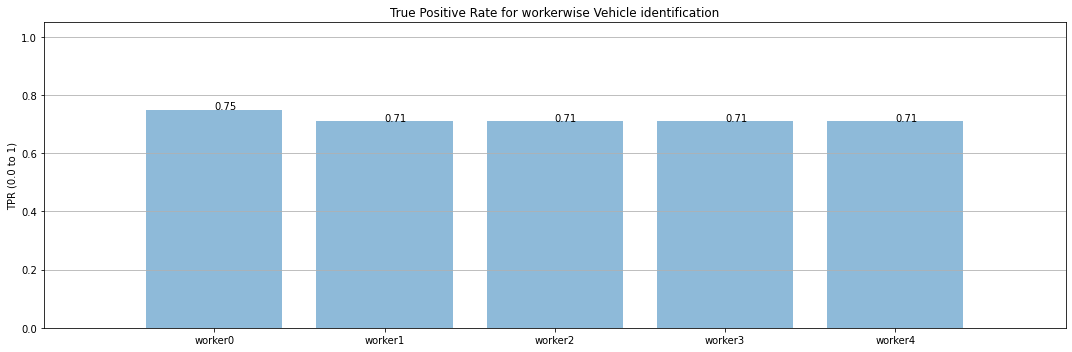

In [107]:
roundedtpr = np.round(list(tpr.values()),2)
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(range(len(workers_map.keys())), roundedtpr, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('TPR (0.0 to 1)')
ax.set_ylim(0,1.05)
ax.set_xlim(-1,len(workers_map.keys()))
ax.set_xticks(range(len(workers_map.keys())))
ax.set_xticklabels(workers_map.keys())
ax.set_title('True Positive Rate for workerwise Vehicle identification')
ax.yaxis.grid(True)
for i in range(len(workers_map.keys())):
    ax.annotate(roundedtpr[i], (i, roundedtpr[i]))
# Save the figure
plt.tight_layout()
#plt.savefig(os.path.join(output_results,'bar_plot_with_error_bars_5workers.png'))
plt.show()

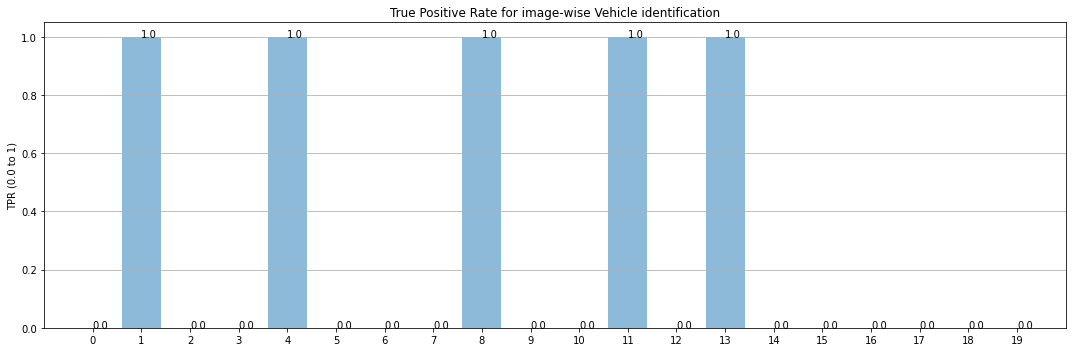

In [108]:
roundedtpr = np.round(list(tpr_url.values()),2)
fig, ax = plt.subplots(figsize=(15,5))
tprurls = list(tpr_url.keys())
ax.bar(range(len(tprurls)), roundedtpr, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('TPR (0.0 to 1)')
ax.set_ylim(0,1.05)
ax.set_xlim(-1,len(tprurls))
ax.set_xticks(range(len(tprurls)))
ax.set_xticklabels(range(len(tprurls)))
ax.set_title('True Positive Rate for image-wise Vehicle identification')
ax.yaxis.grid(True)
for i in range(len(tprurls)):
    ax.annotate(roundedtpr[i], (i, roundedtpr[i]))
# Save the figure
plt.tight_layout()
#plt.savefig(os.path.join(output_results,'bar_plot_with_error_bars_5workers.png'))
plt.show()

In [67]:
workerwise_ann_counts = {}
for k,worker in workers_map.items():
    workerwise_ann_counts[k] = sum([len(item) for item in df[worker]])

In [70]:
workerwise_ann_counts, list(workerwise_ann_counts.values())

({'worker0': 15, 'worker1': 14, 'worker2': 17, 'worker3': 8, 'worker4': 7},
 [15, 14, 17, 8, 7])

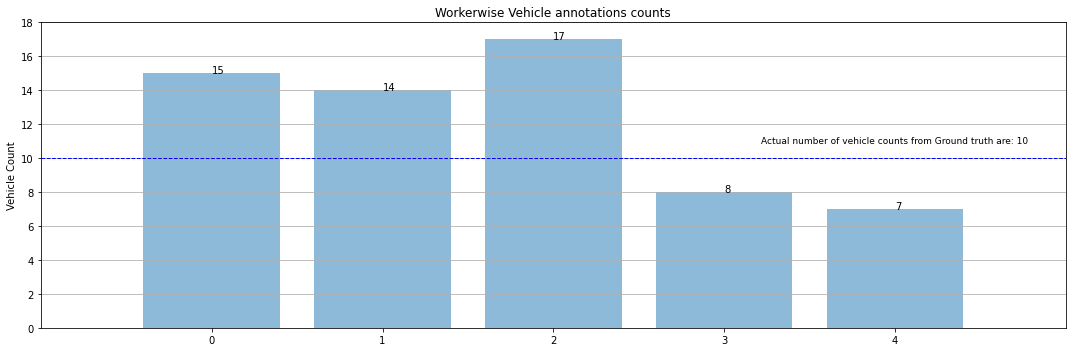

In [91]:
fig, ax = plt.subplots(figsize=(15,5))
wlist = list(workerwise_ann_counts.values())
ax.bar(range(len(workerwise_ann_counts)), wlist, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Vehicle Count')
ax.set_ylim(0,max(wlist)+1)
ax.set_xlim(-1,len(wlist))
ax.set_xticks(range(len(wlist)))
ax.set_xticklabels(range(len(workerwise_ann_counts)))
ax.set_title('Workerwise Vehicle annotations counts')
ax.yaxis.grid(True)
plt.axhline(y=10,linewidth=1, color='blue', ls='--',label='Actual number of vehicle counts from Ground truth') #Actual number of vehicle counts
plt.text(4, 11, 'Actual number of vehicle counts from Ground truth are: 10', fontsize=9, va='center', ha='center', backgroundcolor='w')
for i in range(len(wlist)):
    ax.annotate(wlist[i], (i, wlist[i]))
# Save the figure
plt.tight_layout()
#plt.savefig(os.path.join(output_results,'bar_plot_with_error_bars_5workers.png'))
plt.show()

In [92]:
workerswise_cm.values

array([['0', 3, 5, 1, 7],
       ['1', 5, 4, 2, 5],
       ['2', 5, 5, 2, 7],
       ['3', 5, 2, 2, 1],
       ['4', 5, 2, 2, 0]], dtype=object)

**********************Confusion Matrix, statsitics for worker 0 ****************************************************************
Is this Confusion matrix imbalanced:  False
Predict           Not Vehicle       Vehicle           
Actual
Not Vehicle       7                 5                 

Vehicle           1                 3                 





Overall Statistics : 

95% CI                                                            (0.38778,0.86222)
ACC Macro                                                         0.625
ARI                                                               0.01316
AUNP                                                              0.66667
AUNU                                                              0.66667
Bangdiwala B                                                      0.45312
Bennett S                                                         0.25
CBA                                                               0.47917
CSI                          

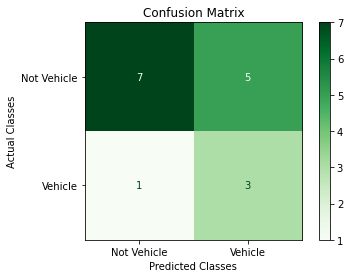

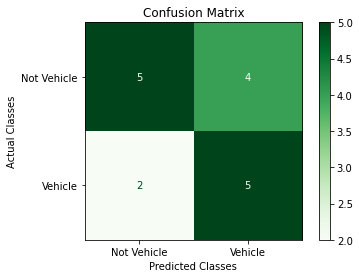

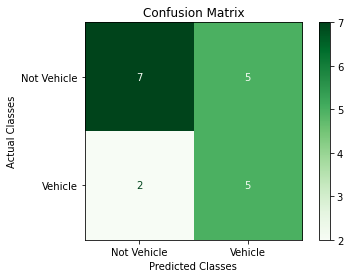

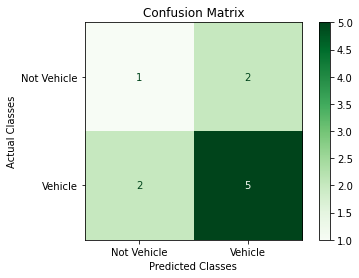

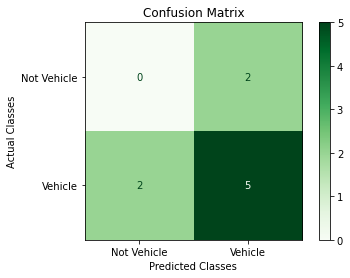

In [95]:
from pycm import *
all_worker_cm = {}
pycmstats = {}
pycm_tprs = {}
for val in workerswise_cm.values.tolist():
    w,tp,fp,fn,tn = val
    print("**********************Confusion Matrix, statsitics for worker %s ****************************************************************"%(w))
    
    cm2 = ConfusionMatrix(matrix={"Vehicle": {"Vehicle": tp, "Not Vehicle":fn}, "Not Vehicle": {"Vehicle": fp, "Not Vehicle": tn}}) # Create CM Directly
    print("Is this Confusion matrix imbalanced: ", cm2.imbalance)
    print(cm2)
    all_worker_cm[w] = cm2
    pycmstats[w] = cm2.overall_stat
    cm2.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib")

In [99]:
pycm_tprs = {}
for w, cmstats in pycmstats.items():
    pycm_tprs[w] = {"tpr_macro":cmstats['TPR Macro'],"tpr_micro": cmstats['TPR Micro']}

In [100]:
pycm_tprs

{'0': {'tpr_macro': 0.6666666666666667, 'tpr_micro': 0.625},
 '1': {'tpr_macro': 0.6349206349206349, 'tpr_micro': 0.625},
 '2': {'tpr_macro': 0.6488095238095238, 'tpr_micro': 0.631578947368421},
 '3': {'tpr_macro': 0.5238095238095238, 'tpr_micro': 0.6},
 '4': {'tpr_macro': 0.35714285714285715, 'tpr_micro': 0.5555555555555556}}

In [101]:
cms = list(all_worker_cm.values())
combined = cms[0].combine(cms[1]).combine(cms[2]).combine(cms[3])
combined.print_matrix()

Predict           Not Vehicle       Vehicle           
Actual
Not Vehicle       20                16                

Vehicle           7                 18                




<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

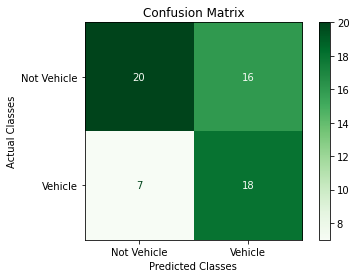

In [102]:
combined.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib")

In [103]:
compare1 = Compare({"worker0":cms[0], "worker1":cms[1]})
print(compare1)

Best : worker0

Rank  Name       Class-Score    Overall-Score
1     worker0    4.95           2.18333
2     worker1    4.7            2.18333



In [104]:
compare1.best_name

'worker0'

In [105]:
urls_vehiclecounts = {}
for url, count in df[['image_url','num_vehicles']].values.tolist():
    urls_vehiclecounts[url] = count

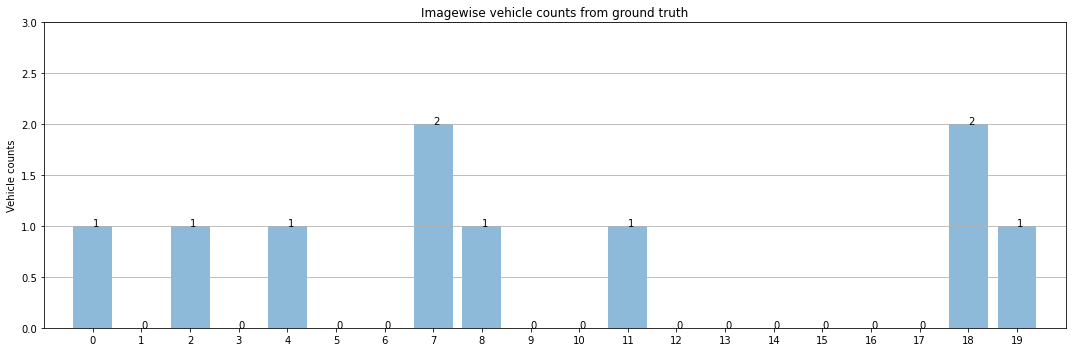

In [106]:
fig, ax = plt.subplots(figsize=(15,5))
values=  list(urls_vehiclecounts.values())
ax.bar(range(len(urls_vehiclecounts)), values, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Vehicle counts')
ax.set_ylim(0,max(values)+1)
ax.set_xlim(-1,len(urls_vehiclecounts))
ax.set_xticks(range(len(urls_vehiclecounts)))
ax.set_xticklabels(range(len(urls_vehiclecounts)))
ax.set_title('Imagewise vehicle counts from ground truth')
ax.yaxis.grid(True)
for i in range(len(values)):
    ax.annotate(values[i], (i, values[i]))
# Save the figure
plt.tight_layout()
#plt.savefig(os.path.join(output_results,'bar_plot_with_error_bars_5workers.png'))
plt.show()

[['https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-6240-6240.png',
  1],
 ['https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10320-5520.png',
  1],
 ['https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-15600-2880.png',
  0],
 ['https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-1920-5760.png',
  0],
 ['https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-12960-4800.png',
  1],
 ['https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10560-5520.png',
  0],
 ['https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-7920-8400.png',
  0],
 ['https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-5040-3600.png',
  2],
 ['https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-22320-3840.png',
  1],
 ['https://mturk-s3-cg.s3.amazonaws.com/t